In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from PIL import Image

In [31]:
# Define the path to the directory containing the folders
base_path = '../Preprocessed Dataset'

# List the folders in the directory
folders = ['IBM Plex Sans Arabic', 'Lemonada', 'Marhey', 'Scheherazade New']

# Create a dictionary to hold the labels for each folder
labels = {folder: i for i, folder in enumerate(folders)}

# Prepare a list to store the image data and labels
data = []

# Loop through each folder and each image within the folder
for folder in folders:
    count = 0
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg'):  # Correctly specify file type in comments and check
            image_path = os.path.join(folder_path, filename)
            try:
                # Load the image and convert to grayscale if not already
                with Image.open(image_path) as img:
                    if img.mode != 'L':
                        img = img.convert('L')
                    # Convert image data to array and binarize
                    image_data = np.array(img)
                    image_data = (image_data > 127).astype(np.uint8)  # Use uint8 for binary data
                    # Append the image data and label to the list
                    data.append((image_data, labels[folder]))
                    count += 1
                    if count == 100: break
            except Exception as e:
                print(f"Failed to process {image_path}: {e}")

# Check what's in the data list
print(f"Total images loaded: {len(data)}")

Total images loaded: 400


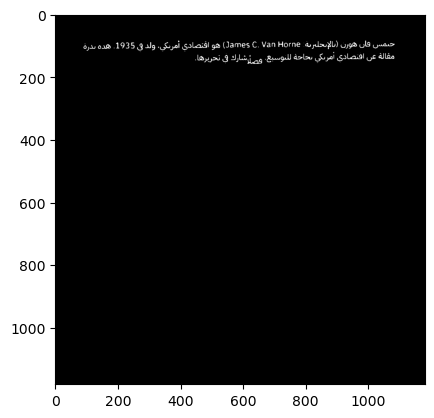

In [54]:
test_image = data[0][0]
plt.imshow(test_image, cmap='gray')

In [58]:
def build_gabor_filters(orientations, frequencies, sigmas):
    filters = []
    for theta in orientations:
        for frequency, sigma in zip(frequencies, sigmas):
            lamda = 1 / frequency  # Wavelength
            gamma = 0.5  # Spatial aspect ratio

            # Adjust the kernel size based on the new sigma
            kernel_size = int(8 * sigma) if int(8 * sigma) % 2 == 1 else int(8 * sigma) + 1  # Ensure kernel size is odd
            kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            filters.append(kernel)
    return filters


def apply_gabor_filters(image, filters):
    responses = []
    for kernel in filters:
        filtered = cv2.filter2D(image, cv2.CV_8U, kernel)  # Corrected data type for single-channel image
        responses.append(filtered)
    return responses

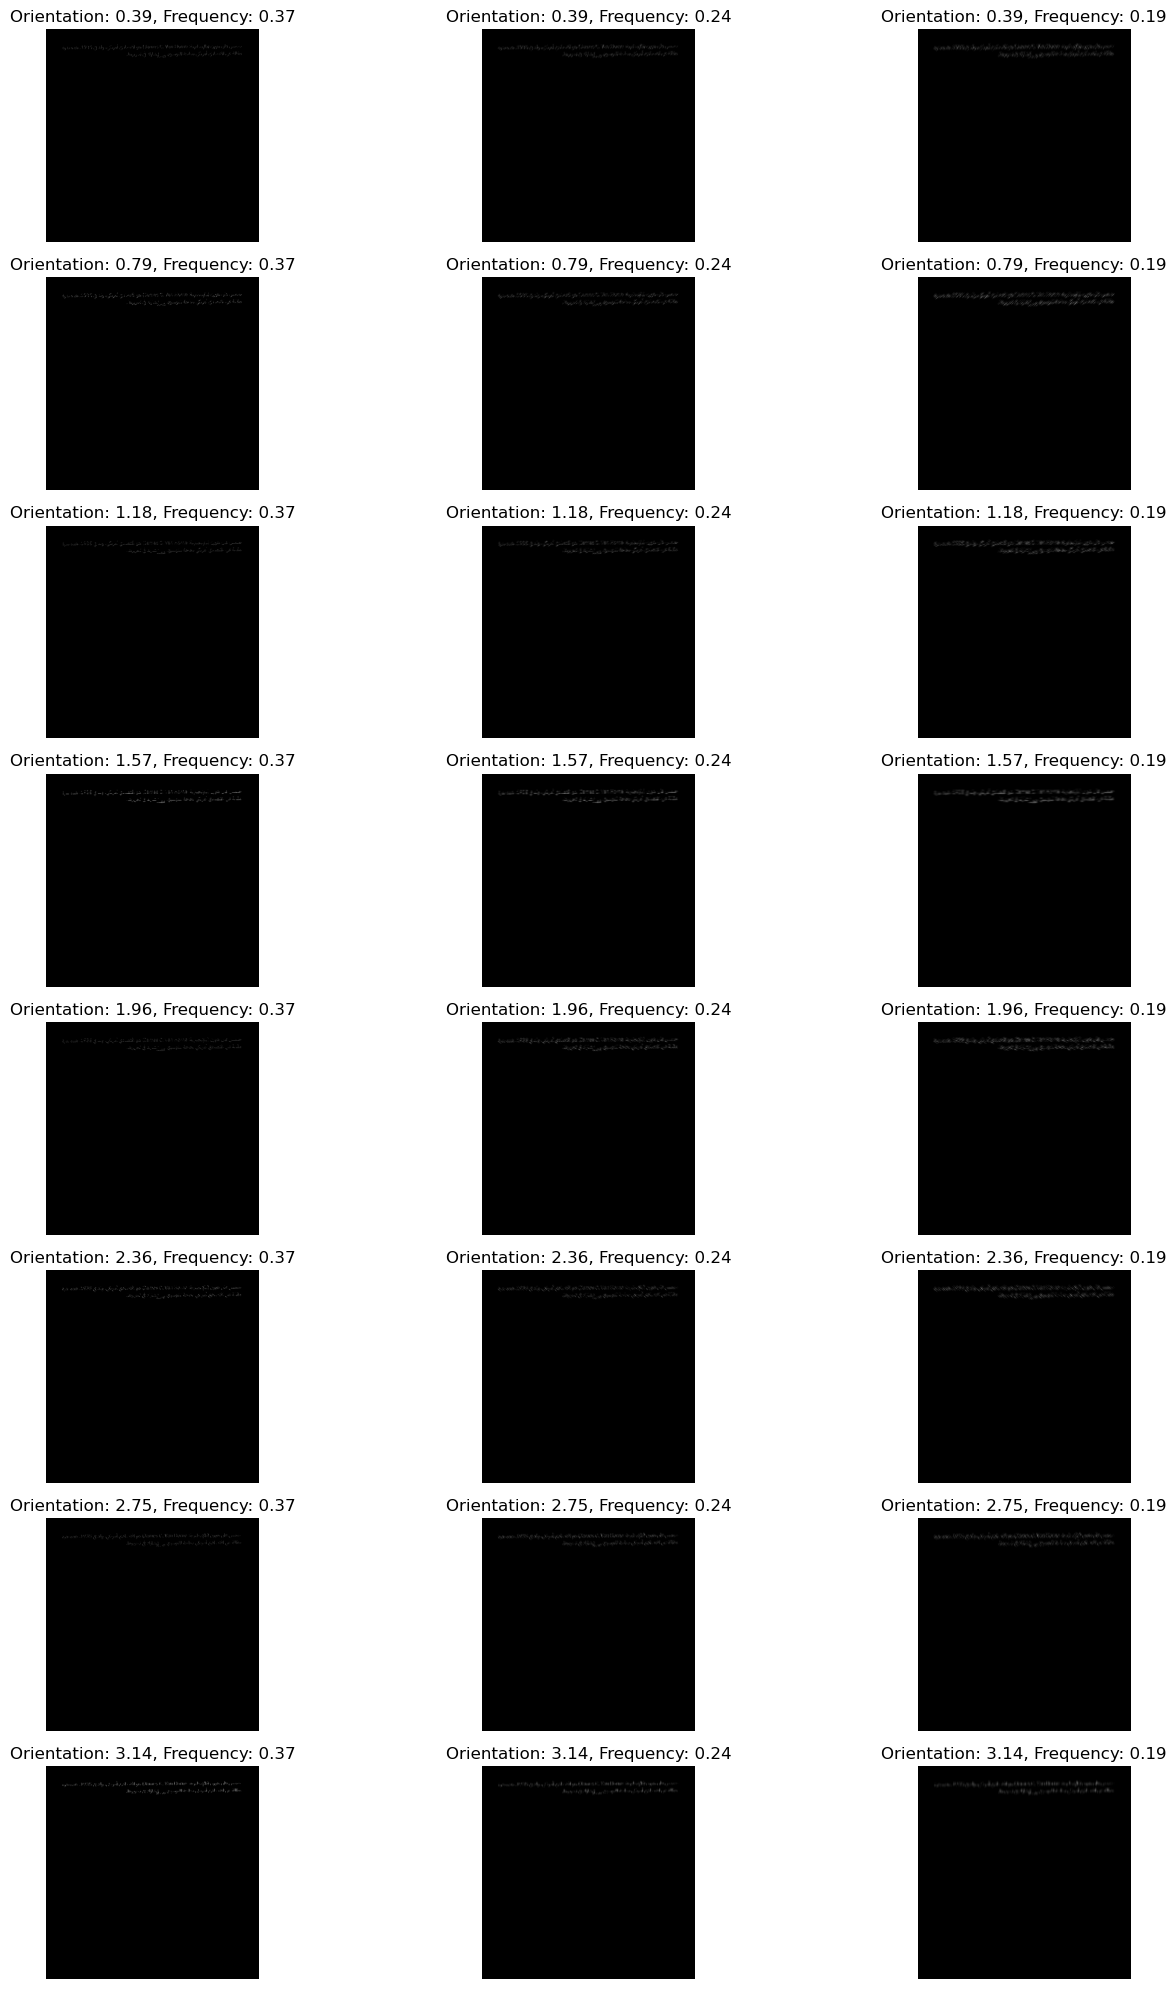

In [59]:
# Define parameters
orientations = [k * np.pi / 8 for k in range(1, 9)]
frequencies = [1/2.7, 1/4.1, 1/5.4]
sigmas = [1, 2, 3]  # Larger values compared to what might be typical for finer filters

# Generate and apply Gabor filters
gabor_filters = build_gabor_filters(orientations, frequencies, sigmas)
gabor_responses = apply_gabor_filters(test_image, gabor_filters)

# Plotting the results
fig, ax = plt.subplots(8, 3, figsize=(15, 20))
for i, response in enumerate(gabor_responses):
    ax[i // 3, i % 3].imshow(response, cmap='gray')
    ax[i // 3, i % 3].set_title(f"Orientation: {orientations[i//3]:.2f}, Frequency: {frequencies[i%3]:.2f}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

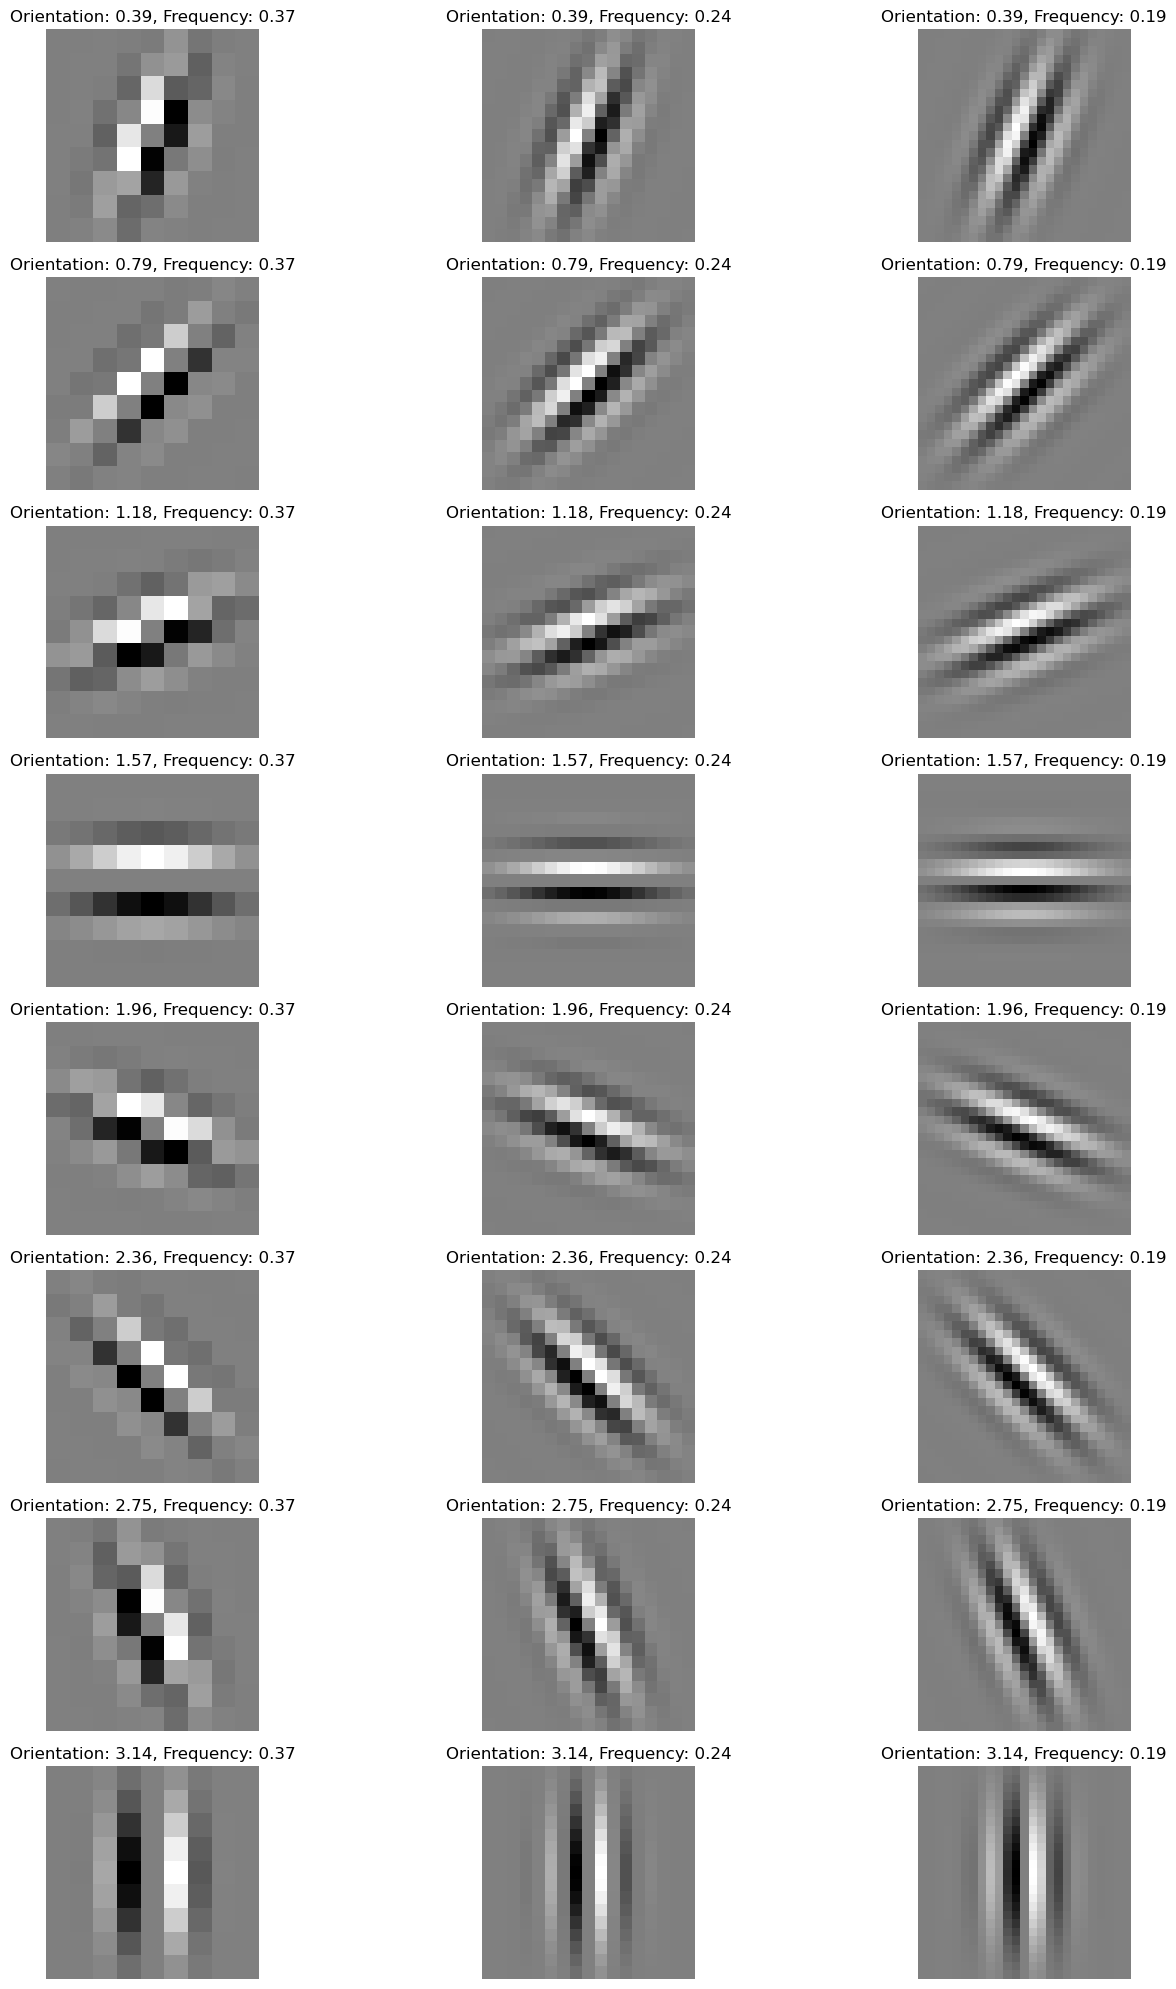

In [60]:
fig, ax = plt.subplots(8, 3, figsize=(15, 20))
for i, filter in enumerate(gabor_filters):
    ax[i // 3, i % 3].imshow(filter, cmap='gray')
    ax[i // 3, i % 3].set_title(f"Orientation: {orientations[i//3]:.2f}, Frequency: {frequencies[i%3]:.2f}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()